**Introducción**

El análisis de datos atmosféricos es fundamental para comprender la calidad del aire y los factores que influyen en su variación a lo largo del tiempo. Este informe presenta un estudio detallado de diversas variables ambientales, incluyendo monóxido de carbono (CO), dióxido de nitrógeno (NO2), ozono (O3), material particulado (PM10 y PM2), dióxido de azufre (SO2), y temperatura (TMP). Utilizando un conjunto de datos históricos, hemos aplicado diversas técnicas de análisis y visualización de datos para identificar patrones temporales y estacionales, así como relaciones subyacentes entre estas variables.

Inicialmente, los datos fueron cargados y limpiados para asegurar su calidad. Posteriormente, se realizaron visualizaciones de tendencias temporales para observar cómo las concentraciones de estas variables han cambiado desde 2004 hasta 2018. Estas visualizaciones permitieron identificar comportamientos anómalos y posibles eventos que afectaron significativamente la calidad del aire.

Para explorar los patrones estacionales, se generaron boxplots mensuales para cada variable, revelando cómo las concentraciones varían a lo largo del año. Este análisis es crucial para detectar estacionalidades y comprender mejor los periodos de mayor y menor contaminación.

Finalmente, se aplicó el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de los datos y visualizar las relaciones entre las variables en un espacio bidimensional. Esta técnica ayudó a identificar patrones y agrupaciones que no son evidentes en el espacio original de los datos.

En conjunto, este informe proporciona una visión comprensiva de la calidad del aire a lo largo del tiempo y las estaciones, utilizando técnicas avanzadas de análisis de datos para facilitar la interpretación y toma de decisiones informadas en el ámbito de la gestión ambiental.

In [ ]:
from google.colab import files
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data_AI_202420.zip to data_AI_202420.zip


In [ ]:
import zipfile
import os

# Nombre del archivo ZIP que has subido
zip_file_name = "data_AI_202420.zip"

# Crear un directorio para descomprimir los archivos
extract_to = "data_AI_202420"
os.makedirs(extract_to, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to)



Este código tiene como objetivo descomprimir un archivo ZIP (data_AI_202420.zip) en un directorio llamado data_AI_202420. Los pasos específicos son:

Importar los módulos necesarios (zipfile y os).
Definir el nombre del archivo ZIP.
Crear un directorio donde se extraerán los archivos.
Abrir el archivo ZIP y extraer su contenido en el directorio creado.
Este proceso automatiza la tarea de descomprimir archivos ZIP, lo cual es útil para manejar archivos comprimidos de manera programática, asegurando que los datos se extraigan y almacenen en la ubicación correcta del sistema de archivos.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Directorio donde están los archivos CSV
data_dir = "/content/data_AI_202420"

# Listar los archivos CSV, excluyendo 'estaciones.csv'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f != 'estaciones.csv']

# Cargar los datos en dataframes
dataframes = []
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    df = df.melt(id_vars=['Date_time'], var_name='station', value_name=file.split('.')[0])
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

# Pivotar el DataFrame para obtener la forma deseada
pivot_data = data.pivot_table(index=['Date_time', 'station'], values=[file.split('.')[0] for file in csv_files], aggfunc='first').reset_index()

# Función para limpiar y convertir las fechas
def clean_date(date_str):
    try:
        return pd.to_datetime(date_str)
    except ValueError:
        return pd.to_datetime(date_str.split('.')[0])

# Aplicar la función de limpieza a la columna 'Date_time'
pivot_data['Date_time'] = pivot_data['Date_time'].apply(clean_date)

# Verificar si hay algún valor nulo en 'Date_time' después de la conversión
print("Número de valores nulos en 'Date_time' después de la conversión:", pivot_data['Date_time'].isnull().sum())

# Eliminar filas con 'Date_time' nulo
pivot_data = pivot_data.dropna(subset=['Date_time'])

# Interpolación para manejar datos faltantes
pivot_data = pivot_data.sort_values(by=['Date_time'])
pivot_data.set_index('Date_time', inplace=True)
pivot_data.interpolate(method='time', inplace=True)
pivot_data.reset_index(inplace=True)

# Cargar estaciones.csv para agregar coordenadas
stations_file_path = os.path.join(data_dir, 'estaciones.csv')
stations_df = pd.read_csv(stations_file_path)

# Unir las coordenadas al DataFrame final
final_data = pd.merge(pivot_data, stations_df, how='left', left_on='station', right_on='STATION')
final_data = final_data.drop(columns=['STATION'])
# Mostrar el DataFrame final
print(final_data.head())

# Guardar el DataFrame final en un archivo CSV
final_data.to_csv('final_data.csv', index=False)

Número de valores nulos en 'Date_time' después de la conversión: 0
   Date_time     station  CO     DIR    HUM  LLU  NO2  O3  PM10  PM2  PRE  \
0 2004-01-01   BELISARIO NaN  336.54  98.06  NaN  NaN NaN   NaN  NaN  NaN   
1 2004-01-01   CARAPUNGO NaN  180.02  74.78  NaN  NaN NaN   NaN  NaN  NaN   
2 2004-01-01      CENTRO NaN  153.87  98.56  NaN  NaN NaN   NaN  NaN  NaN   
3 2004-01-01  COTOCOLLAO NaN  109.65  98.49  NaN  NaN NaN   NaN  NaN  NaN   
4 2004-01-01    EL_CAMAL NaN  253.95  76.89  NaN  NaN NaN   NaN  NaN  NaN   

      RS    SO2    TMP   VEL       LAT        LON  
0   0.00  11.40   9.93  0.52 -0.184731 -78.495989  
1  37.39  39.43  12.73  2.86 -0.095480 -78.449792  
2   0.11   9.58  12.36  0.86 -0.221403 -78.513967  
3   8.73  42.14  10.41  0.44 -0.107840 -78.497191  
4  23.69   8.17  12.57  1.86       NaN        NaN  


Importación de Módulos:

pandas para manipulación de datos.
StandardScaler de sklearn.preprocessing para estandarización.
os para operaciones del sistema de archivos.
Definición de Directorio y Listado de Archivos:

Define el directorio donde están los archivos CSV.
Lista todos los archivos CSV en el directorio, excluyendo estaciones.csv.
Carga y Transformación de Datos:

Carga cada archivo CSV en un DataFrame.
Transforma los DataFrames de formato ancho a largo usando melt().
Concatenación y Pivotación de DataFrames:

Concatena todos los DataFrames en uno solo.
Crea una tabla pivote para organizar los datos por Date_time y station.
Limpieza y Conversión de Fechas:

Define y aplica una función para limpiar y convertir fechas en Date_time.
Verifica y elimina filas con fechas nulas.
Interpolación de Datos Faltantes:

Ordena el DataFrame por Date_time.
Interpola datos faltantes basándose en el tiempo.
Integración de Coordenadas:

Carga estaciones.csv para obtener coordenadas.
Une estas coordenadas al DataFrame principal.
Visualización y Guardado del DataFrame Final:

Muestra las primeras filas del DataFrame final.
Guarda el DataFrame final en un archivo CSV llamado final_data.csv.
Este flujo de trabajo automatiza la carga, limpieza, transformación y fusión de datos de múltiples archivos CSV, asegurando que los datos faltantes se manejen adecuadamente mediante interpolación y que se integren datos geográficos adicionales.


Dropdown(description='Variable:', index=1, options=('CO', 'DIR', 'HUM', 'LLU', 'NO2', 'O3', 'PM10', 'PM2', 'PR…

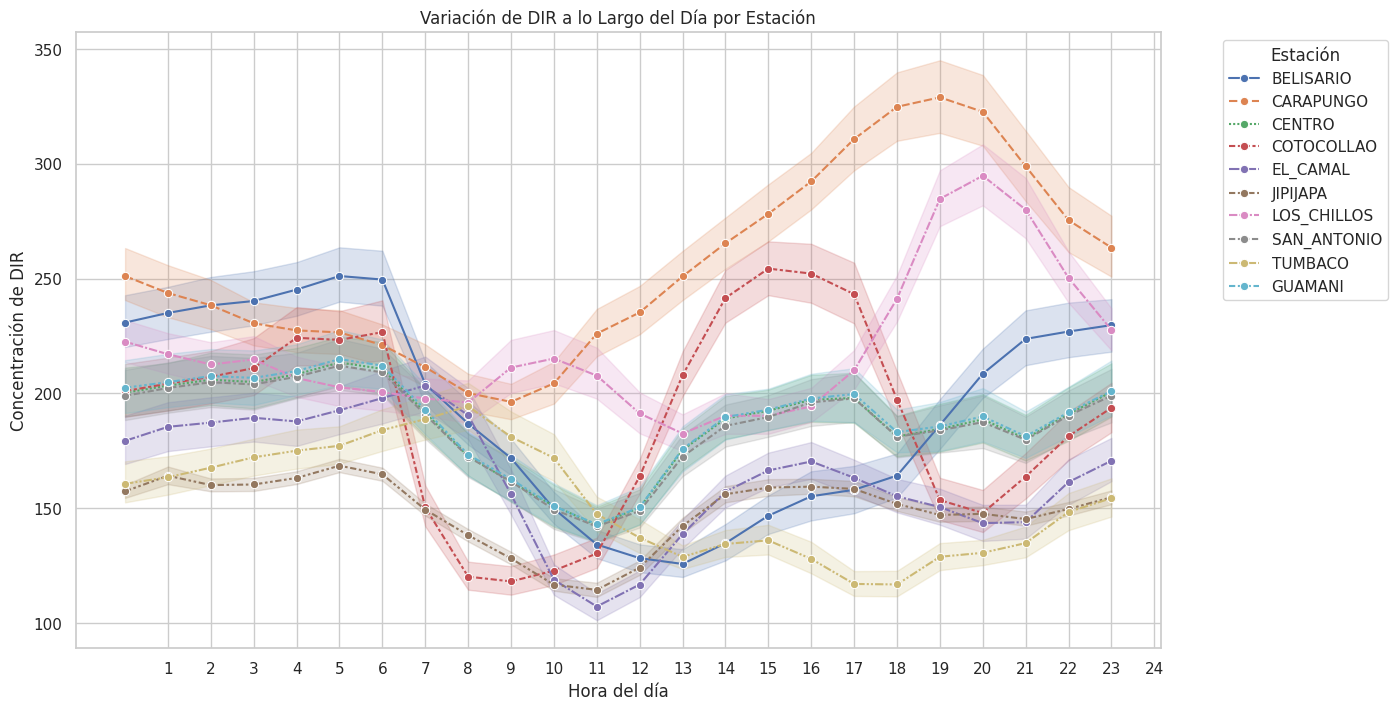

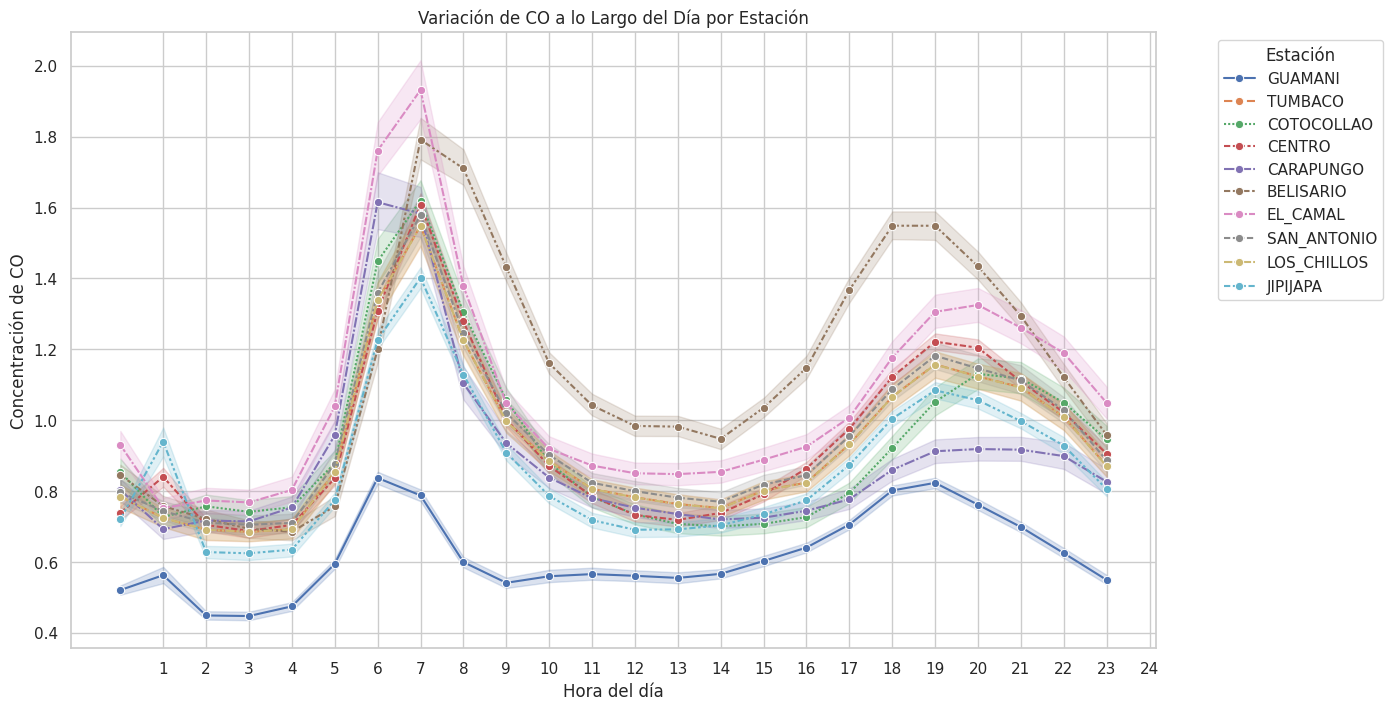

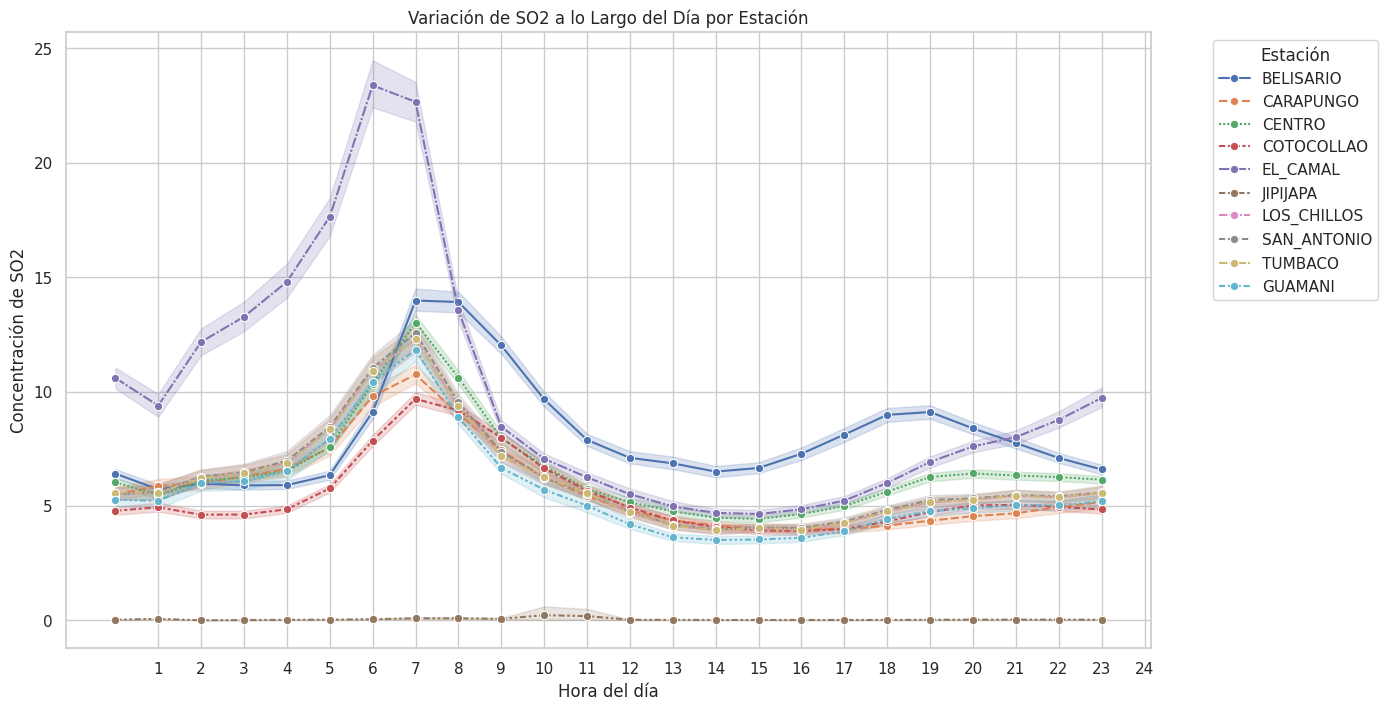

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Suponiendo que el DataFrame final_data ya está cargado y limpio
# Agregar columna de horas
final_data['hour'] = final_data['Date_time'].dt.hour

# Definir la función para graficar
def plot_variable(variable):
    # Filtrar datos para la variable seleccionada y eliminar nulos
    plot_data = final_data[['hour', 'station', variable]].dropna()

    # Configurar el estilo de los gráficos
    sns.set(style="whitegrid")

    # Crear la gráfica con líneas y marcadores
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=plot_data, x='hour', y=variable, hue='station', marker='o', style='station')

    # Personalizar las etiquetas del gráfico
    plt.xlabel('Hora del día')
    plt.ylabel(f'Concentración de {variable}')
    plt.title(f'Variación de {variable} a lo Largo del Día por Estación')
    plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(ticks=range(1, 25))

    # Mostrar el gráfico
    plt.show()

# Crear el dropdown
dropdown = widgets.Dropdown(
    options=['CO', 'DIR', 'HUM', 'LLU', 'NO2', 'O3', 'PM10', 'PM2', 'PRE', 'RS', 'SO2', 'TMP', 'VEL'],
    value='DIR',
    description='Variable:',
)

# Crear una función que se ejecute cuando se cambie el valor del dropdown
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_variable(change['new'])

# Asignar la función al dropdown
dropdown.observe(on_change)

# Mostrar el dropdown
display(dropdown)

# Graficar la variable inicial
plot_variable(dropdown.value)


El código permite visualizar de manera interactiva la variación de diferentes variables ambientales a lo largo del día en diversas estaciones. Utiliza pandas para manipulación de datos, seaborn y matplotlib para la creación de gráficos, y ipywidgets para generar un menú desplegable interactivo. El DataFrame final_data se enriquece con una columna hour, que extrae la hora de Date_time. La función plot_variable filtra los datos para la variable seleccionada, crea un gráfico de líneas con marcadores, y personaliza las etiquetas y el título del gráfico. Un menú desplegable permite seleccionar la variable a graficar, actualizando el gráfico dinámicamente. Este enfoque facilita la exploración visual de cómo varían las concentraciones de diferentes contaminantes y parámetros ambientales a lo largo del día en distintas estaciones, mejorando el análisis y la interpretación de los datos.

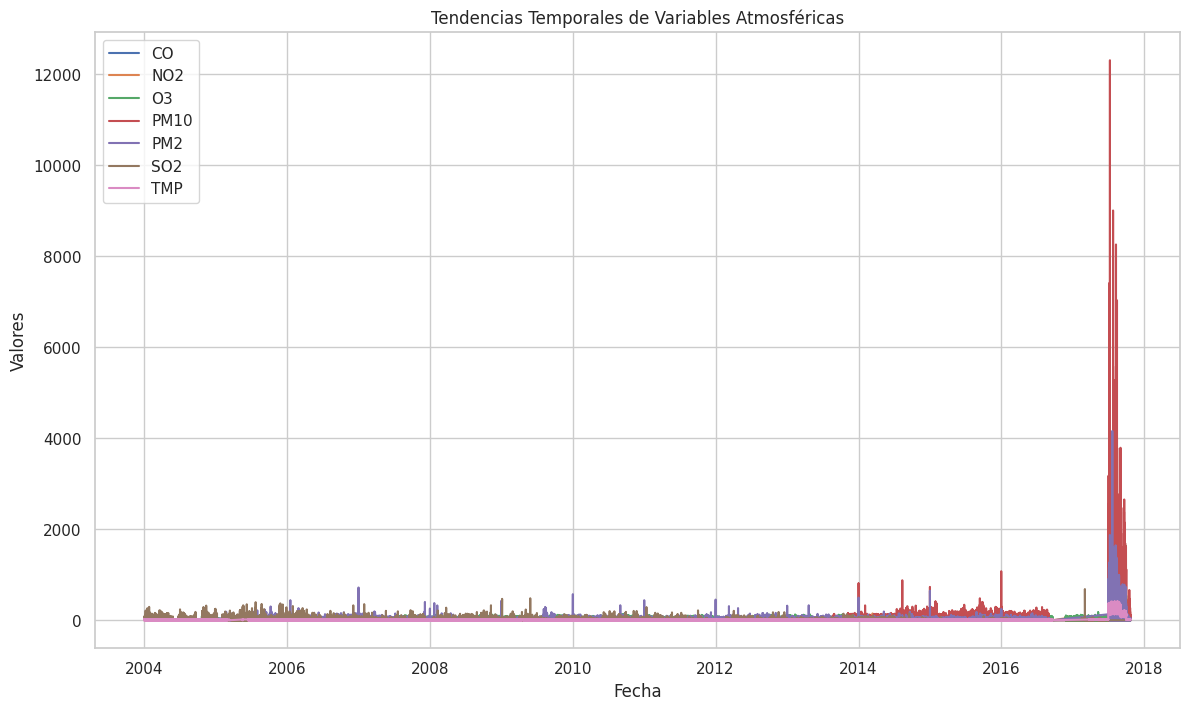

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Seleccionar algunas variables para visualizar
variables = ['CO', 'NO2', 'O3', 'PM10', 'PM2', 'SO2', 'TMP']

# Graficar cada variable
plt.figure(figsize=(14, 8))
for var in variables:
    if var in final_data.columns:
        plt.plot(final_data['Date_time'], final_data[var], label=var)

plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Tendencias Temporales de Variables Atmosféricas')
plt.legend()
plt.show()


El código configura el estilo de gráficos usando seaborn y luego selecciona varias variables atmosféricas (CO, NO2, O3, PM10, PM2, SO2, TMP) para visualización. Para cada variable presente en el DataFrame final_data, se crea una gráfica de líneas que muestra su tendencia temporal a lo largo de la columna Date_time. El gráfico resultante tiene un tamaño de 14x8 pulgadas, con etiquetas en los ejes para la fecha y los valores, un título descriptivo ("Tendencias Temporales de Variables Atmosféricas"), y una leyenda que identifica cada variable representada. Este enfoque proporciona una visión comparativa de cómo varían las concentraciones de diferentes contaminantes y parámetros atmosféricos a lo largo del tiempo.


El gráfico resultante muestra las tendencias temporales de varias variables atmosféricas (CO, NO2, O3, PM10, PM2, SO2, TMP) a lo largo del tiempo. Cada línea en el gráfico representa una de estas variables y cómo sus valores cambian desde 2004 hasta 2018. La gráfica revela un comportamiento anómalo de ciertas variables a partir del año 2016, donde los valores aumentan drásticamente. Las etiquetas en los ejes X e Y indican la fecha y los valores respectivos de las variables, y la leyenda identifica cada variable representada. Este tipo de visualización es útil para observar patrones y detectar posibles eventos o cambios significativos en las mediciones ambientales a lo largo del tiempo.

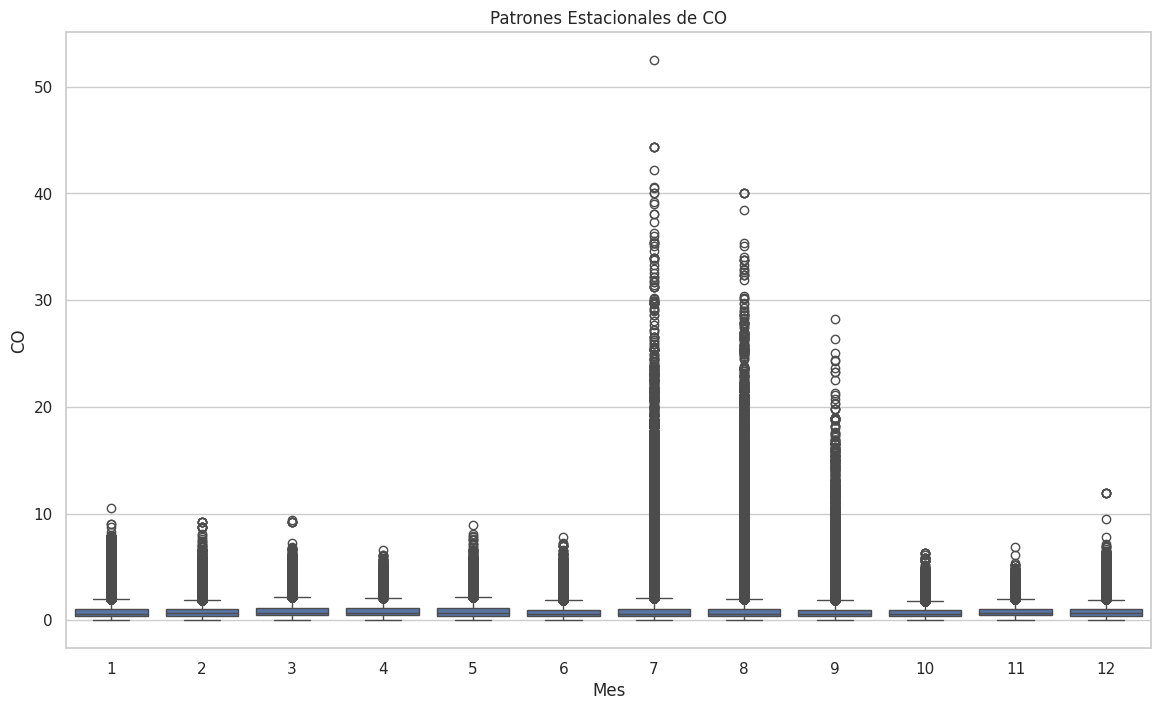

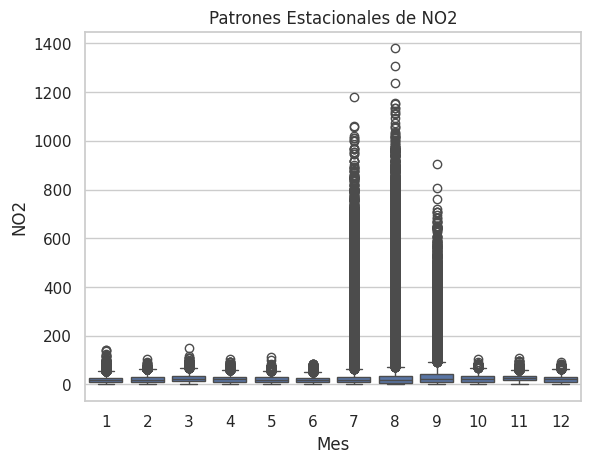

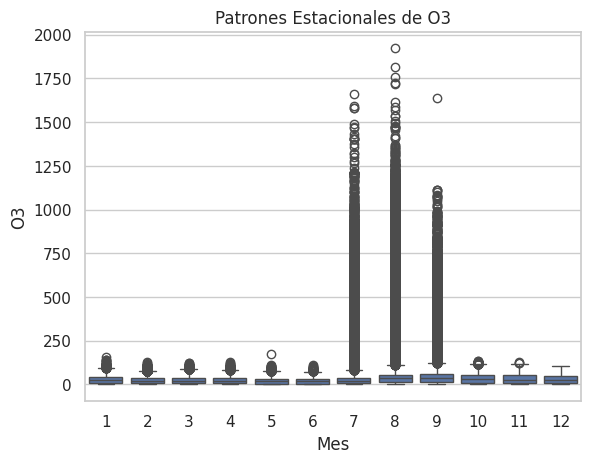

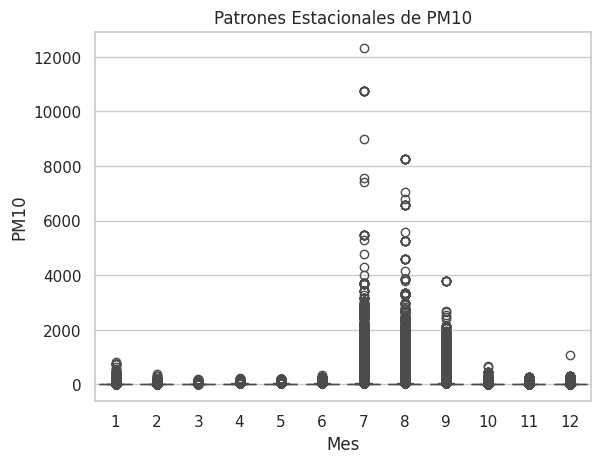

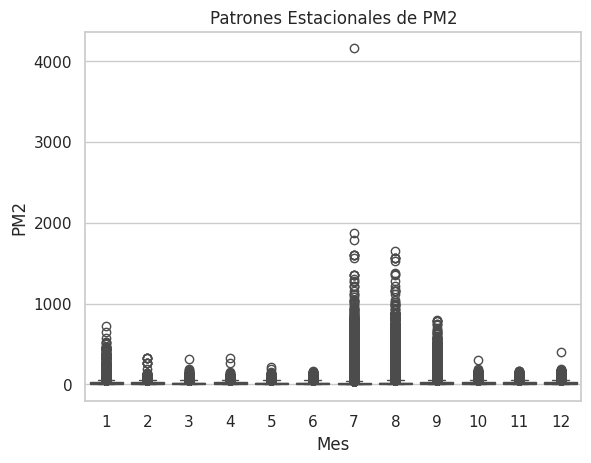

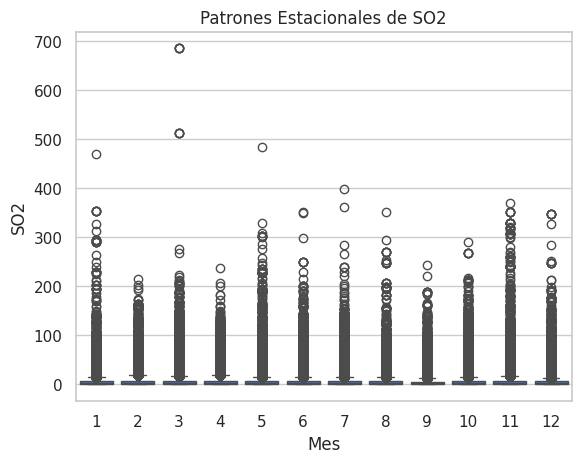

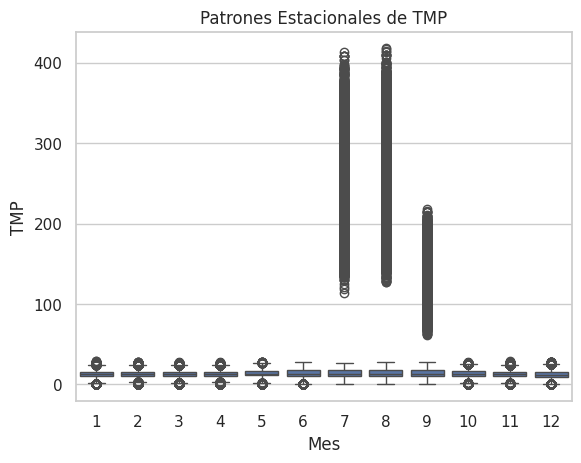

In [ ]:
# Agregar columnas para año y mes
final_data['year'] = final_data['Date_time'].dt.year
final_data['month'] = final_data['Date_time'].dt.month

# Graficar un boxplot para cada variable por mes
plt.figure(figsize=(14, 8))
for var in variables:
    if var in final_data.columns:
        sns.boxplot(x='month', y=var, data=final_data)
        plt.xlabel('Mes')
        plt.ylabel(var)
        plt.title(f'Patrones Estacionales de {var}')
        plt.show()


El código agrega columnas para el año y el mes al DataFrame final_data, extrayendo esta información de la columna Date_time. Luego, genera boxplots para cada una de las variables atmosféricas seleccionadas (CO, NO2, O3, PM10, PM2, SO2, TMP), mostrando la distribución mensual de los valores de cada variable. Estos gráficos permiten identificar patrones estacionales, revelando cómo las concentraciones de estos contaminantes y parámetros cambian a lo largo del año. En el gráfico resultante para el CO, se observan picos significativos en los meses de julio, agosto y septiembre, indicando posibles fuentes o condiciones que aumentan la concentración de monóxido de carbono durante estos meses. Esta visualización es útil para detectar tendencias y variaciones estacionales en los datos ambientales.

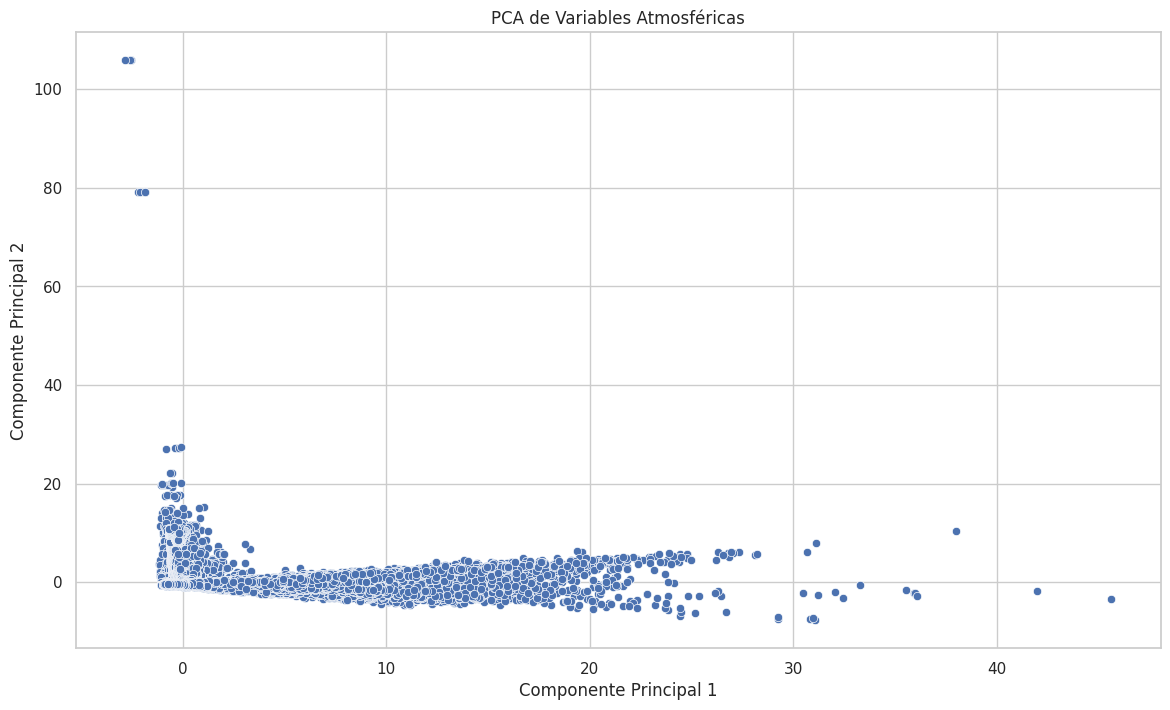

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionar solo las columnas numéricas y eliminar las filas con valores nulos
numeric_data = final_data[variables].dropna()

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Graficar los componentes principales
plt.figure(figsize=(14, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Variables Atmosféricas')
plt.show()


El código aplica Análisis de Componentes Principales (PCA) a las variables atmosféricas para reducir su dimensionalidad y visualizar las relaciones subyacentes entre ellas en un espacio bidimensional. Primero, selecciona solo las columnas numéricas y elimina las filas con valores nulos. Luego, estandariza los datos usando StandardScaler para asegurar que cada variable tenga media cero y desviación estándar uno. Se aplica PCA, extrayendo dos componentes principales que capturan la mayor variabilidad posible en los datos. Los componentes principales se almacenan en un nuevo DataFrame, pca_df. Finalmente, se grafica un scatter plot de estos componentes principales (PC1 y PC2), mostrando cómo las observaciones se distribuyen en el espacio reducido. Este gráfico permite identificar patrones y posibles agrupaciones entre las observaciones, facilitando la interpretación de la estructura de los datos.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Cargar datos estáticos
final_data = pd.read_csv('/content/final_data.csv')

# Asegurarse de que la columna 'hour' esté presente
final_data['hour'] = pd.to_datetime(final_data['Date_time']).dt.hour

# Crear características de fecha adicionales si aún no se han creado
final_data['dayofweek'] = pd.to_datetime(final_data['Date_time']).dt.dayofweek
final_data['day'] = pd.to_datetime(final_data['Date_time']).dt.day
final_data['month'] = pd.to_datetime(final_data['Date_time']).dt.month
final_data['year'] = pd.to_datetime(final_data['Date_time']).dt.year

# Crear características de retardo (lags) y estadísticas móviles (rolling statistics)
for lag in [1, 2, 3, 4, 5]:
    final_data[f'PM2_lag{lag}'] = final_data['PM2'].shift(lag)
final_data['PM2_roll_mean'] = final_data['PM2'].rolling(window=3).mean()
final_data['PM2_roll_std'] = final_data['PM2'].rolling(window=3).std()

# Eliminar filas con valores nulos generados por los lags y rolling statistics
final_data.dropna(inplace=True)

# Convertir las columnas categóricas en variables dummy
final_data = pd.get_dummies(final_data, columns=['station'], drop_first=True)

# Seleccionar las características y la variable objetivo
features = ['hour', 'dayofweek', 'day', 'month', 'year',
            'PM2_lag1', 'PM2_lag2', 'PM2_lag3', 'PM2_lag4', 'PM2_lag5',
            'PM2_roll_mean', 'PM2_roll_std'] + [col for col in final_data.columns if col.startswith('station_')]

# Eliminar la columna objetivo de la lista de características si está presente
if 'PM2' in features:
    features.remove('PM2')

# Separar las características y la variable objetivo
X = final_data[features]
y = final_data['PM2']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 7.058029088467842


In [ ]:
pip install mlforecast xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
pip install scikit-learn

In [ ]:
pip install mlforecast

In [ ]:
!pip install --upgrade mlforecast

In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean


In [ ]:
# Cargar el DataFrame final desde el archivo CSV
final_data = pd.read_csv('/content/final_data.csv')
# Asegurarse de que 'Date_time' sea de tipo datetime
final_data['Date_time'] = pd.to_datetime(final_data['Date_time'])
final_data = final_data.dropna()
final_data = final_data.fillna(0)
train = final_data.copy()
train = train.sort_values(by=["station", "Date_time"])
train.head()

,Date_time,station,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL,LAT,LON
751596,2012-12-09 00:00:00,BELISARIO,0.346667,266.59,61.32,0.0,32.04,12.970000,16.221299,5.84,725.21,0.0,2.740,13.95,0.97,-0.184731,-78.495989
751613,2012-12-09 01:00:00,BELISARIO,0.323333,17.68,64.19,0.0,28.17,21.096667,16.221656,10.08,724.53,0.0,3.265,13.70,1.85,-0.184731,-78.495989
751623,2012-12-09 02:00:00,BELISARIO,0.290000,22.36,64.76,0.0,14.98,27.043333,16.222013,6.57,724.53,0.0,3.810,13.42,1.68,-0.184731,-78.495989
751634,2012-12-09 03:00:00,BELISARIO,0.330000,8.41,70.99,0.0,17.97,22.030000,16.222371,6.11,724.53,0.0,3.080,12.84,1.32,-0.184731,-78.495989
751643,2012-12-09 04:00:00,BELISARIO,0.280000,5.51,70.13,0.0,14.08,26.820000,16.222728,11.89,724.53,0.0,2.000,12.82,1.27,-0.184731,-78.495989


El código en la imagen realiza varias operaciones con un DataFrame utilizando la biblioteca pandas y algunas herramientas de machine learning. Primero, se importan las bibliotecas necesarias, incluyendo pandas, sklearn, xgboost, y mlforecast. Luego, se carga un archivo CSV llamado final_data.csv y se asegura que la columna Date_time sea de tipo datetime. Después, se eliminan filas con valores nulos y se rellenan valores faltantes. El DataFrame se ordena por la estación (station) y el tiempo (Date_time). Finalmente, se muestra una vista previa de las primeras filas del DataFrame ordenado. El resultado muestra un subconjunto de datos de calidad del aire con varias mediciones ambientales (como CO, PM10, NO2, etc.) para la estación "BELISARIO" en diferentes momentos del tiempo.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from window_ops.ewm import ewm_mean
from mlforecast.target_transforms import Differences

In [ ]:
models = [make_pipeline(SimpleImputer(),
                        RandomForestRegressor(random_state=0, n_estimators=100)),
        XGBRegressor(random_state=0, n_estimators=100)]


model = MLForecast(models=models,
                freq='D',
                lags=[4,8,10],  # encontrar un valor de lag adecuado
                lag_transforms={
                    1: [ExpandingMean()],
                    2: [RollingMean(window_size=2), RollingMean(window_size=4), (ewm_mean, 0.5)],
                    4: [RollingMean(window_size=2), RollingMean(window_size=4), (ewm_mean, 0.5)],
                },
                date_features=['dayofweek', 'day', 'month'],
                target_transforms=[Differences([1,2])],
                num_threads=6)
# Change Mean for Min or Max
model.fit(train, id_col='station', time_col='Date_time', target_col='PM2')

h = 10  # temporal window
predictions = model.predict(h=h)
predictions.rename(columns={"Pipeline": "RFRegressor"}, inplace=True)

In [ ]:
predictions

,station,Date_time,RandomForestRegressor,XGBRegressor
0,BELISARIO,2017-10-23 23:00:00,2.814783,0.335586
1,BELISARIO,2017-10-24 23:00:00,5.763250,5.615591
2,BELISARIO,2017-10-25 23:00:00,2.531708,3.818627
3,BELISARIO,2017-10-26 23:00:00,2.725742,8.540709
4,BELISARIO,2017-10-27 23:00:00,-0.670600,6.400139
...,...,...,...,...
65,TUMBACO,2017-10-28 23:00:00,5.559318,4.487357
66,TUMBACO,2017-10-29 23:00:00,20.029952,14.782096
67,TUMBACO,2017-10-30 23:00:00,11.478593,5.621055
68,TUMBACO,2017-10-31 23:00:00,27.993085,16.083380


El código mostrado en las imágenes realiza la predicción de niveles de PM2 usando dos modelos de machine learning: RandomForestRegressor y XGBRegressor. Primero, se importan las bibliotecas necesarias y se crea una tubería de procesamiento (pipeline) que incluye un imputador (SimpleImputer) y los modelos de regresión mencionados.

Se define un objeto MLForecast con los modelos, frecuencia diaria ('D'), lags específicos ([4, 8, 10]), y algunas transformaciones de ventanas (ExpandingMean, RollingMean) y transformaciones de objetivos (Differences).

El modelo se ajusta (fit) utilizando los datos de entrenamiento, con las columnas de estación (station), tiempo (Date_time), y el objetivo (PM2). Luego, se predice para una ventana temporal (h=10), y se renombran las columnas del DataFrame de predicciones.

El resultado muestra las predicciones de PM2 para las estaciones "BELISARIO" y "TUMBACO" en varias fechas. Las columnas incluyen las predicciones hechas por los dos modelos (RandomForestRegressor y XGBRegressor). Las predicciones varían según el modelo y la fecha, proporcionando un marco de comparación entre los dos enfoques de regresión para la serie temporal de datos ambientales.

In [ ]:
pred_melted = pd.melt(predictions, id_vars=["Date_time", "station"])
pred_melted["PM2"] = pred_melted.value.round().astype(int)
pred_melted

,Date_time,station,variable,value,PM2
0,2017-10-23 23:00:00,BELISARIO,RandomForestRegressor,2.814783,3
1,2017-10-24 23:00:00,BELISARIO,RandomForestRegressor,5.763250,6
2,2017-10-25 23:00:00,BELISARIO,RandomForestRegressor,2.531708,3
3,2017-10-26 23:00:00,BELISARIO,RandomForestRegressor,2.725742,3
4,2017-10-27 23:00:00,BELISARIO,RandomForestRegressor,-0.670600,-1
...,...,...,...,...,...
135,2017-10-28 23:00:00,TUMBACO,XGBRegressor,4.487357,4
136,2017-10-29 23:00:00,TUMBACO,XGBRegressor,14.782096,15
137,2017-10-30 23:00:00,TUMBACO,XGBRegressor,5.621055,6
138,2017-10-31 23:00:00,TUMBACO,XGBRegressor,16.083380,16


En esta imagen, se realiza una transformación del DataFrame predictions utilizando la función melt de pandas. Esta transformación convierte las columnas RandomForestRegressor y XGBRegressor en filas, creando una columna llamada variable que indica el nombre del modelo y una columna value que contiene las predicciones. Luego, la columna PM2 se redondea y se convierte a tipo entero.

El DataFrame resultante (pred_melted) tiene cinco columnas:

Date_time: La fecha y hora de la predicción.
station: La estación donde se realizaron las mediciones.
variable: El modelo que generó la predicción (RandomForestRegressor o XGBRegressor).
value: El valor de la predicción original.
PM2: El valor redondeado de la predicción, convertido a entero.
Este formato es útil para análisis comparativos y visualizaciones, permitiendo ver cómo se comportan las predicciones de diferentes modelos en un solo DataFrame.

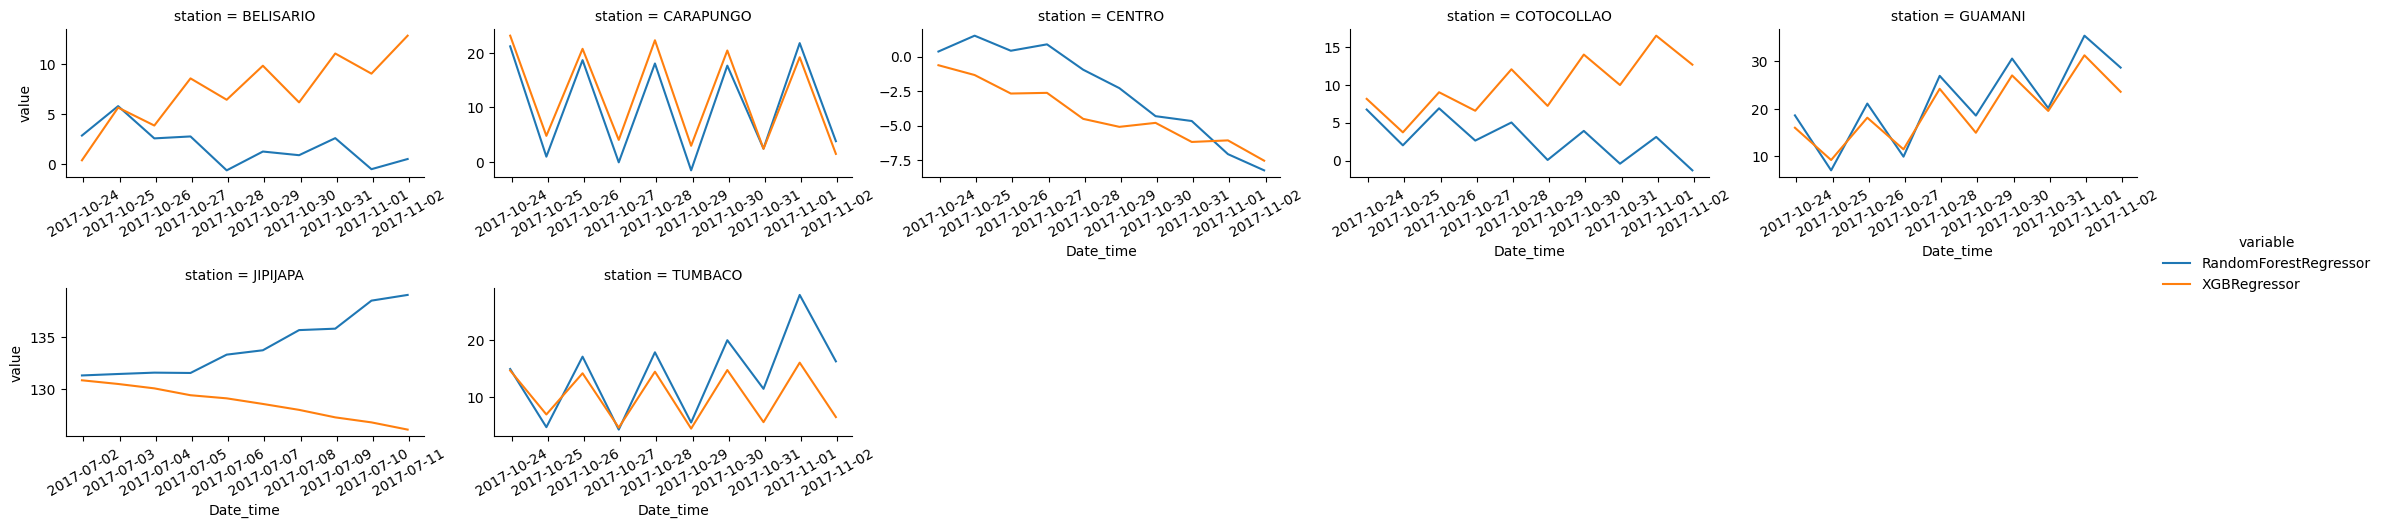

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(pred_melted, x="Date_time", y="value",
            hue="variable", col="station", kind="line", col_wrap=5,
            facet_kws={'sharey': False, 'sharex': False}, height=2.5,aspect=1.75
            )
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.75)

El código utiliza seaborn y matplotlib para visualizar las predicciones de PM2 realizadas por los modelos RandomForestRegressor y XGBRegressor. Empleando sns.relplot, se crea un gráfico de líneas donde el eje X representa el tiempo (Date_time), el eje Y muestra los valores de las predicciones (value), y los colores (hue) diferencian entre los modelos. Las gráficas se organizan por estaciones (col="station"), mostrando múltiples subgráficas ajustadas en filas con col_wrap=5. La configuración incluye rotación de etiquetas del eje X para mejor legibilidad y ajuste de espacios verticales entre subgráficas. El resultado facilita la comparación visual del rendimiento de ambos modelos a través del tiempo en diferentes estaciones.

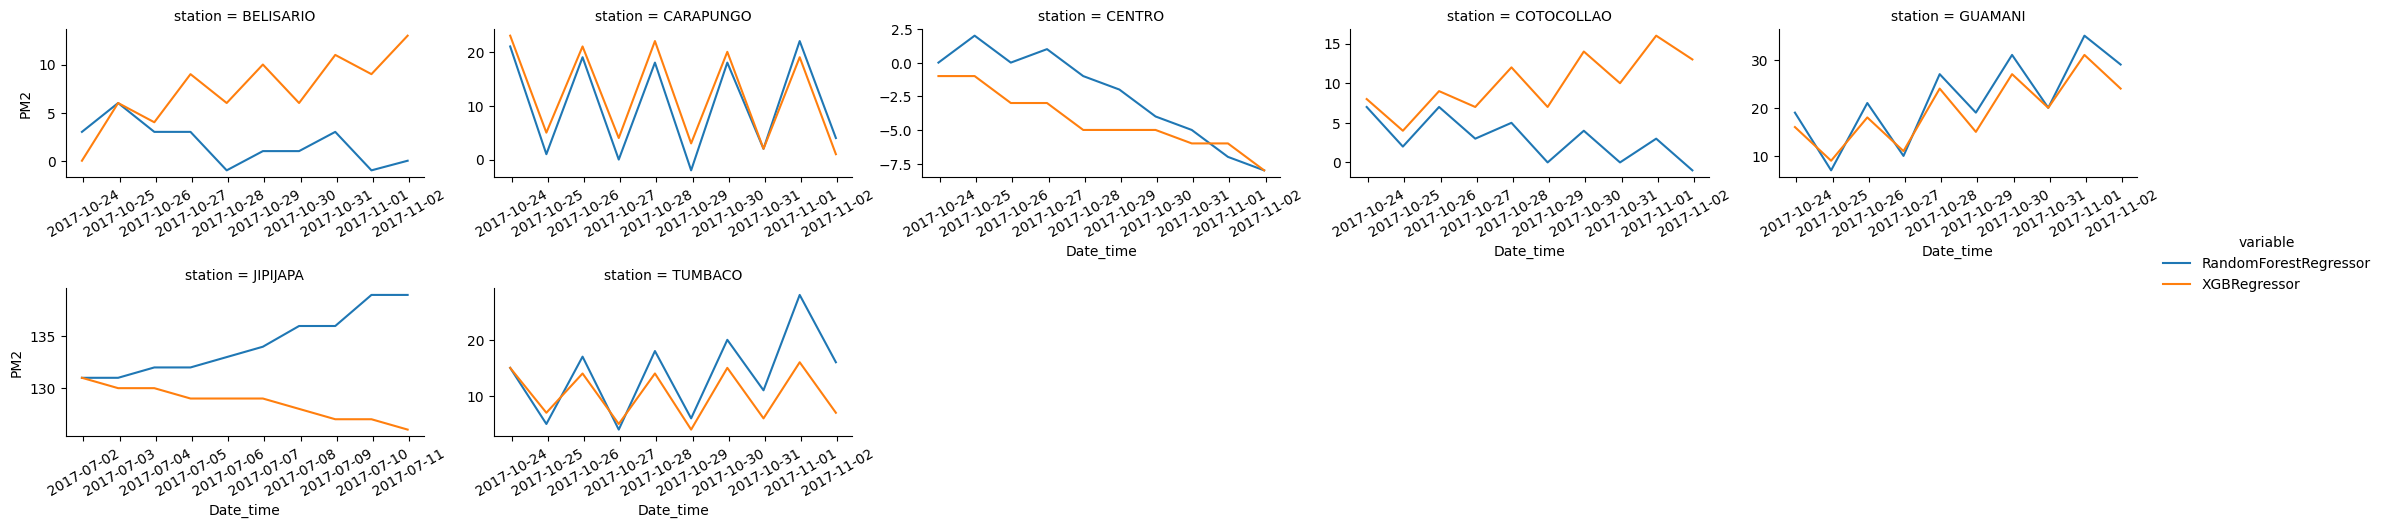

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(pred_melted, x="Date_time", y="PM2",
            hue="variable", col="station", kind="line",
            col_wrap=5,
            facet_kws={'sharey': False, 'sharex': False},
            height=2.5,aspect=1.75
            )
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.75)

In [ ]:
# Evaluar las predicciones
from sklearn.metrics import mean_squared_error
import numpy as np

# Comparar las predicciones con los valores reales
# Asegúrate de que y_test y y_pred tengan la misma longitud
y_test = final_data['PM2'].iloc[-len(predictions):] # Corregir el slicing de y_test
y_pred = predictions['RandomForestRegressor'].values

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 48.61483894063501


El código evalúa las predicciones del modelo RandomForestRegressor calculando el error cuadrático medio de raíz (RMSE). Primero, se importan mean_squared_error de sklearn.metrics y numpy. Se preparan las series de valores reales (y_test) y predicciones (y_pred) asegurando que tengan la misma longitud. y_test se extrae de los datos originales, tomando los valores finales de PM2 correspondientes a la longitud de las predicciones. y_pred se obtiene de las predicciones del modelo RandomForestRegressor. Luego, se calcula el RMSE utilizando la raíz cuadrada del error cuadrático medio y se imprime el resultado. El RMSE calculado es 48.61, lo que indica la magnitud promedio del error de las predicciones del modelo.

In [ ]:
train.shape

(272259, 17)

In [ ]:
staciones = ['BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI', 'JIPIJAPA', 'LOS CHILLOS', 'SAN ANTONIO', 'TUMBACO']

In [ ]:
train = train.sort_values(by=["station", "Date_time"])
test_data = []
for prodi in staciones:
    test_data += [train.query("station=='"+prodi+"'").tail(10)]
test_data = pd.concat(test_data)
test_data

,Date_time,station,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL,LAT,LON
1142503,2017-10-22 14:00:00,BELISARIO,0.520,353.83,51.28,0.0,9.56,46.16,41.62,1.37,724.45,688.91,0.92,18.92,2.96,-0.184731,-78.495989
1142512,2017-10-22 15:00:00,BELISARIO,0.480,7.92,50.15,0.0,9.72,40.09,38.16,6.37,724.17,255.58,0.92,18.43,2.19,-0.184731,-78.495989
1142520,2017-10-22 16:00:00,BELISARIO,0.420,357.67,56.62,0.0,9.13,33.31,62.16,19.05,724.49,203.72,0.92,17.56,3.07,-0.184731,-78.495989
1142523,2017-10-22 17:00:00,BELISARIO,0.430,357.15,62.75,0.0,12.64,26.81,34.60,27.33,724.90,39.91,0.92,16.10,2.73,-0.184731,-78.495989
1142539,2017-10-22 18:00:00,BELISARIO,0.540,5.41,61.96,0.0,19.70,17.10,45.33,8.65,725.54,1.35,0.92,15.52,2.33,-0.184731,-78.495989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142541,2017-10-22 19:00:00,TUMBACO,0.000,63.73,75.21,0.0,31.37,27.42,46.02,14.82,770.54,0.00,0.92,16.43,1.39,-0.214956,-78.403211
1142550,2017-10-22 20:00:00,TUMBACO,0.000,48.69,76.47,0.0,32.51,28.90,66.57,9.13,771.43,0.00,0.92,15.80,1.72,-0.214956,-78.403211
1142559,2017-10-22 21:00:00,TUMBACO,1.022,32.80,77.91,0.0,35.67,29.82,33.38,0.00,771.90,0.00,0.92,15.17,1.56,-0.214956,-78.403211
1142568,2017-10-22 22:00:00,TUMBACO,0.500,67.04,80.83,0.0,0.00,22.57,80.22,21.42,772.31,0.00,0.92,14.64,0.85,-0.214956,-78.403211


El código prepara un subconjunto de datos para su uso en el modelado o evaluación. Primero, se determina la forma del DataFrame train, que contiene 272,259 filas y 17 columnas. Luego, se define una lista de estaciones de monitoreo de calidad del aire. El DataFrame train se ordena por station y Date_time. Se inicializa una lista test_data para almacenar los últimos 10 registros de cada estación. Utilizando un bucle for, se itera sobre cada estación, se filtran los últimos 10 registros (tail(10)) de cada estación, y se agregan a test_data. Finalmente, test_data se convierte en un DataFrame concatenado, mostrando 70 filas con las últimas mediciones de las estaciones seleccionadas, incluyendo diversas variables ambientales como CO, PM2.5, O3, entre otras.

In [ ]:
train_new = pd.concat([train, test_data]).drop_duplicates(keep=False)
print(train_new.shape)

(272189, 17)


In [ ]:
models = [make_pipeline(SimpleImputer(),
                        RandomForestRegressor(random_state=0, n_estimators=100)),
        XGBRegressor(random_state=0, n_estimators=100)]


model = MLForecast(models=models,
                freq='D',
                lags=[4,8,10],  # encontrar un valor de lag adecuado
                lag_transforms={  # rolling feature engineering
                    1: [ExpandingMean()],
                    2: [RollingMean(window_size=2), RollingMean(window_size=4), (ewm_mean, 0.5)],
                    4: [RollingMean(window_size=2), RollingMean(window_size=4), (ewm_mean, 0.5)],
                },
                date_features=['dayofweek', 'day', 'month'],
                target_transforms=[Differences([1,2])],
                num_threads=6)
# Change Mean for Min or Max
model.fit(train_new, id_col='station', time_col='Date_time', target_col='PM2')

h = 10  # temporal window to predict
predictions = model.predict(h=h)
predictions.rename(columns={"Pipeline": "RFRegressor"}, inplace=True)

In [ ]:
predictions.head(10)

,station,Date_time,RandomForestRegressor,XGBRegressor
0,BELISARIO,2017-10-23 13:00:00,7.568757,9.412393
1,BELISARIO,2017-10-24 13:00:00,4.944707,4.674588
2,BELISARIO,2017-10-25 13:00:00,5.222497,5.348030
3,BELISARIO,2017-10-26 13:00:00,2.891807,-1.207776
4,BELISARIO,2017-10-27 13:00:00,0.796007,-0.503860
5,BELISARIO,2017-10-28 13:00:00,-1.037976,-6.035707
6,BELISARIO,2017-10-29 13:00:00,-1.184876,-5.847978
7,BELISARIO,2017-10-30 13:00:00,-1.966547,-11.913163
8,BELISARIO,2017-10-31 13:00:00,-2.499695,-10.860917
9,BELISARIO,2017-11-01 13:00:00,-3.376324,-15.698639


El código mostrado concatena el DataFrame original train con los últimos datos de cada estación almacenados en test_data, eliminando duplicados y creando un nuevo DataFrame train_new con 272,189 filas y 17 columnas. Luego, se define y entrena un modelo de MLForecast utilizando dos regresores (RandomForestRegressor y XGBRegressor) dentro de un pipeline que incluye imputación de valores faltantes y transformaciones de características como medias móviles y diferencias. El modelo se entrena con la columna de tiempo (Date_time) y la variable objetivo (PM2). Posteriormente, se realizan predicciones para una ventana temporal de 10 unidades (h=10). Las predicciones para la estación "BELISARIO" se muestran en un DataFrame con columnas para cada modelo, indicando que las predicciones del RandomForestRegressor y XGBRegressor varían significativamente a lo largo del tiempo.

In [ ]:
test_data = test_data.sort_values(by=["station", "Date_time"])
test_data.head(10)

,Date_time,station,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL,LAT,LON
1142503,2017-10-22 14:00:00,BELISARIO,0.52,353.83,51.28,0.0,9.56,46.16,41.62,1.37,724.45,688.91,0.92,18.92,2.96,-0.184731,-78.495989
1142512,2017-10-22 15:00:00,BELISARIO,0.48,7.92,50.15,0.0,9.72,40.09,38.16,6.37,724.17,255.58,0.92,18.43,2.19,-0.184731,-78.495989
1142520,2017-10-22 16:00:00,BELISARIO,0.42,357.67,56.62,0.0,9.13,33.31,62.16,19.05,724.49,203.72,0.92,17.56,3.07,-0.184731,-78.495989
1142523,2017-10-22 17:00:00,BELISARIO,0.43,357.15,62.75,0.0,12.64,26.81,34.60,27.33,724.90,39.91,0.92,16.10,2.73,-0.184731,-78.495989
1142539,2017-10-22 18:00:00,BELISARIO,0.54,5.41,61.96,0.0,19.70,17.10,45.33,8.65,725.54,1.35,0.92,15.52,2.33,-0.184731,-78.495989
1142548,2017-10-22 19:00:00,BELISARIO,0.45,357.39,61.95,0.0,16.46,18.27,46.02,12.11,726.16,0.99,0.92,14.92,2.21,-0.184731,-78.495989
1142557,2017-10-22 20:00:00,BELISARIO,0.49,0.68,61.50,0.0,17.97,16.21,66.57,4.08,726.89,1.22,0.92,14.73,1.79,-0.184731,-78.495989
1142566,2017-10-22 21:00:00,BELISARIO,0.49,351.99,62.87,0.0,19.08,13.36,33.38,11.48,727.19,0.74,0.92,14.28,1.54,-0.184731,-78.495989
1142575,2017-10-22 22:00:00,BELISARIO,0.53,350.81,66.65,0.0,21.79,8.94,80.22,7.77,727.54,0.28,0.92,13.60,1.38,-0.184731,-78.495989
1142578,2017-10-22 23:00:00,BELISARIO,0.39,357.20,66.65,0.0,9.60,20.79,0.00,3.58,727.44,1.23,0.92,13.39,1.64,-0.184731,-78.495989


Se muestra el DataFrame test_data después de haber sido ordenado por las columnas station y Date_time. El DataFrame contiene las últimas 10 entradas para cada estación, incluyendo diversas mediciones ambientales como CO, DIR, HUM, Lluvia, NO2, O3, PM10, PM2.5, y más. Este subconjunto de datos se ordena para facilitar su uso en evaluación o predicciones. Las primeras 10 filas del DataFrame ordenado corresponden a la estación "BELISARIO", mostrando las mediciones en diferentes momentos del día 22 de octubre de 2017, incluyendo valores para contaminantes y condiciones meteorológicas. Este paso es crucial para asegurar que los datos estén organizados cronológicamente antes de su uso en modelado o análisis posteriores.

In [ ]:
test_data["RandomForestRegressor"] = list(predictions["RandomForestRegressor"])
test_data["XGBRegressor"] = list(predictions["XGBRegressor"])
test_data.head()

,Date_time,station,CO,DIR,HUM,LLU,NO2,O3,PM10,PM2,PRE,RS,SO2,TMP,VEL,LAT,LON,RandomForestRegressor,XGBRegressor
1142503,2017-10-22 14:00:00,BELISARIO,0.52,353.83,51.28,0.0,9.56,46.16,41.62,1.37,724.45,688.91,0.92,18.92,2.96,-0.184731,-78.495989,7.568757,9.412393
1142512,2017-10-22 15:00:00,BELISARIO,0.48,7.92,50.15,0.0,9.72,40.09,38.16,6.37,724.17,255.58,0.92,18.43,2.19,-0.184731,-78.495989,4.944707,4.674588
1142520,2017-10-22 16:00:00,BELISARIO,0.42,357.67,56.62,0.0,9.13,33.31,62.16,19.05,724.49,203.72,0.92,17.56,3.07,-0.184731,-78.495989,5.222497,5.348030
1142523,2017-10-22 17:00:00,BELISARIO,0.43,357.15,62.75,0.0,12.64,26.81,34.60,27.33,724.90,39.91,0.92,16.10,2.73,-0.184731,-78.495989,2.891807,-1.207776
1142539,2017-10-22 18:00:00,BELISARIO,0.54,5.41,61.96,0.0,19.70,17.10,45.33,8.65,725.54,1.35,0.92,15.52,2.33,-0.184731,-78.495989,0.796007,-0.503860


El código agrega las predicciones generadas por los modelos RandomForestRegressor y XGBRegressor al DataFrame test_data. Se crea una lista de predicciones para cada modelo a partir del DataFrame predictions y se asignan a nuevas columnas en test_data. Las primeras cinco filas del DataFrame resultante se muestran, incluyendo las columnas originales con las mediciones ambientales y dos nuevas columnas con las predicciones de PM2.5 (RandomForestRegressor y XGBRegressor). Estas nuevas columnas permiten comparar directamente las predicciones de los modelos con las mediciones reales para evaluar su rendimiento.

In [ ]:
test_data1 = test_data.drop(columns=["CO", "DIR", "HUM", "LLU", "NO2", "O3", "PM10", "PRE", "RS", "SO2", "TMP", "VEL", "TMP", "VEL", "LAT", "LON"])
td1_melted = pd.melt(test_data1, id_vars=["Date_time", "station"])
td1_melted["PM2"] = td1_melted.value.round().astype(int)
td1_melted

,Date_time,station,variable,value,PM2
0,2017-10-22 14:00:00,BELISARIO,PM2,1.370000,1
1,2017-10-22 15:00:00,BELISARIO,PM2,6.370000,6
2,2017-10-22 16:00:00,BELISARIO,PM2,19.050000,19
3,2017-10-22 17:00:00,BELISARIO,PM2,27.330000,27
4,2017-10-22 18:00:00,BELISARIO,PM2,8.650000,9
...,...,...,...,...,...
205,2017-10-22 19:00:00,TUMBACO,XGBRegressor,2.635948,3
206,2017-10-22 20:00:00,TUMBACO,XGBRegressor,1.567512,2
207,2017-10-22 21:00:00,TUMBACO,XGBRegressor,-0.468411,0
208,2017-10-22 22:00:00,TUMBACO,XGBRegressor,2.278845,2


El proceso transforma un DataFrame de predicciones al eliminar columnas irrelevantes y reorganizar los datos en un formato largo, facilitando la comparación entre predicciones de diferentes modelos y los valores reales de PM2. Se muestran las predicciones y valores reales de PM2 en un solo DataFrame, con columnas que indican la estación, el tiempo, el modelo de predicción o el valor real, y los valores redondeados. Esto permite analizar y visualizar las predicciones de PM2 comparando diferentes modelos y valores reales de una manera estructurada y clara.

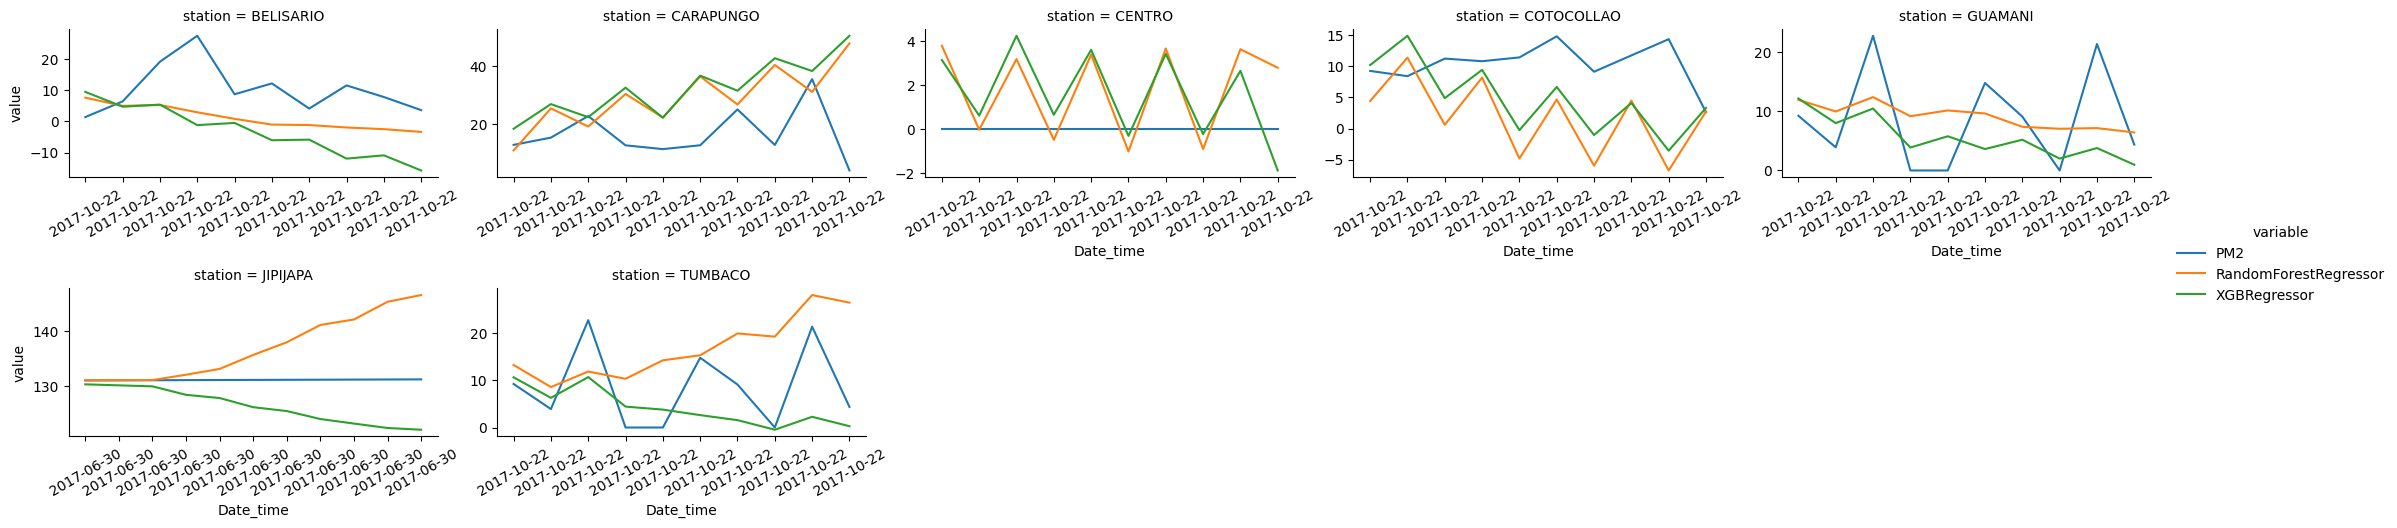

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(td1_melted, x="Date_time", y="value",
            hue="variable", col="station", kind="line", col_wrap=5,
            facet_kws={'sharey': False, 'sharex': False}, height=2.5,aspect=1.75
            )
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.75)

La visualización final muestra gráficos de líneas que comparan los valores reales de PM2 con las predicciones de dos modelos, RandomForestRegressor y XGBRegressor, para varias estaciones de monitoreo. Cada subgráfico representa una estación diferente y muestra cómo los valores predichos por ambos modelos se comparan con los valores reales a lo largo del tiempo. Los colores diferencian las líneas de los valores reales y las predicciones de los dos modelos, proporcionando una clara comparación visual del rendimiento de cada modelo en diferentes estaciones. La rotación de las etiquetas del eje X y el ajuste del espacio entre subgráficos mejoran la legibilidad y organización de la presentación de los datos.

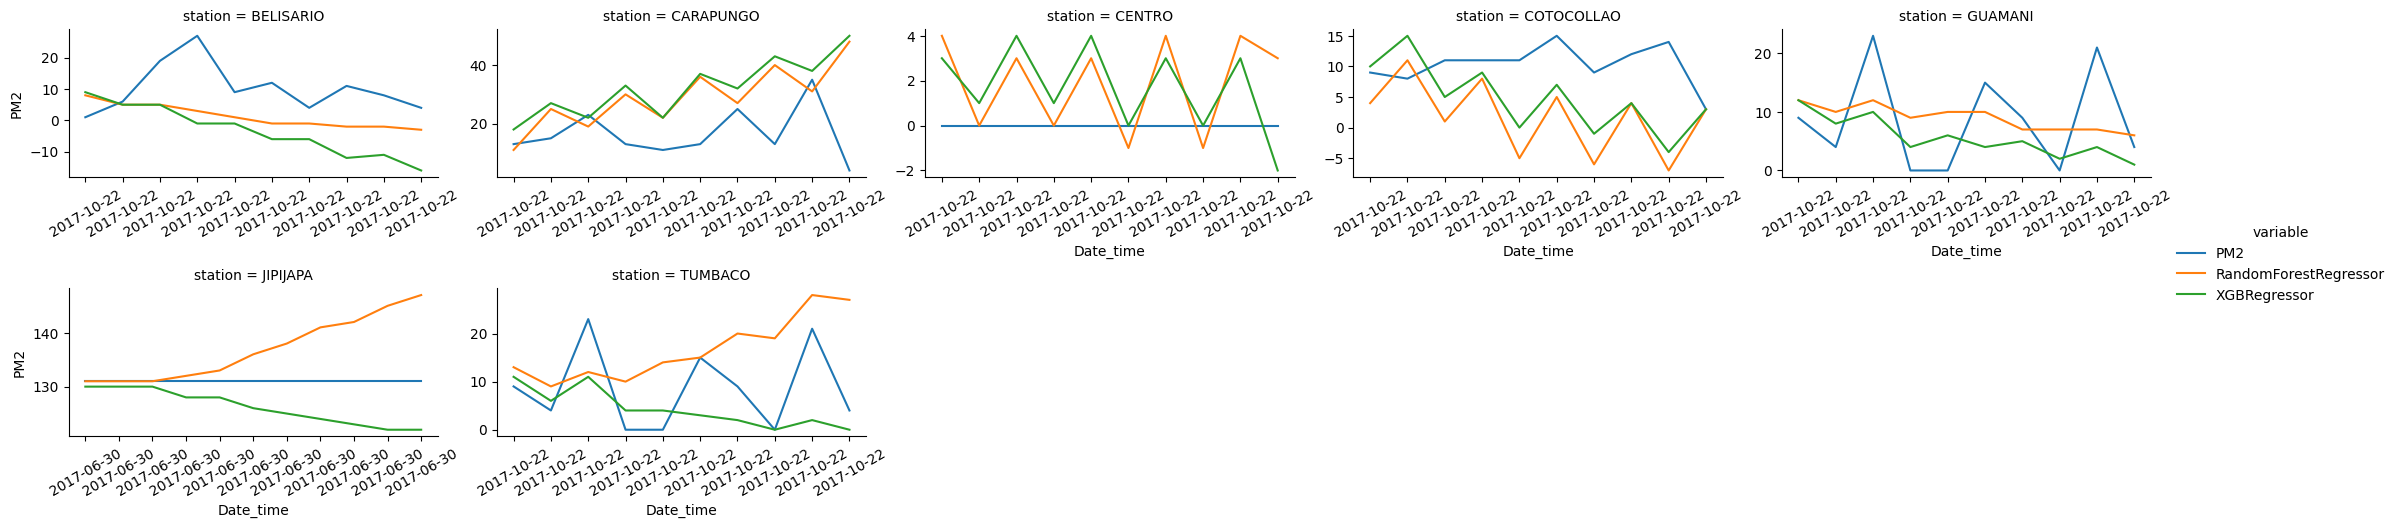

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(td1_melted, x="Date_time", y="PM2",
            hue="variable", col="station", kind="line",
            col_wrap=5,
            facet_kws={'sharey': False, 'sharex': False},
            height=2.5,aspect=1.75
            )
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.75)

La visualización final muestra gráficos de líneas comparando las predicciones de PM2 de dos modelos, RandomForestRegressor y XGBRegressor, con los valores reales, a lo largo del tiempo para varias estaciones. Cada subgráfico representa una estación diferente, con el eje X indicando el tiempo y el eje Y los valores de PM2. Las líneas de diferentes colores representan los valores reales y las predicciones de los modelos. La organización de las subparcelas facilita la comparación entre las estaciones, mostrando cómo las predicciones de los modelos se alinean con los valores observados de PM2 en cada ubicación específica.

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Calcular los errores por estación
stations = test_data['station'].unique()
errors = []

for station in stations:
    station_data = test_data[test_data['station'] == station]
    y_test = station_data['PM2']

    rf_predictions = station_data['RandomForestRegressor']
    xgbr_predictions = station_data['XGBRegressor']

    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
    rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

    xgbr_mae = mean_absolute_error(y_test, xgbr_predictions)
    xgbr_rmse = mean_squared_error(y_test, xgbr_predictions, squared=False)
    xgbr_mape = mean_absolute_percentage_error(y_test, xgbr_predictions)

    errors.append([station, rf_mae, rf_rmse, rf_mape, xgbr_mae, xgbr_rmse, xgbr_mape])

errors_df = pd.DataFrame(errors, columns=["Station", "RF MAE", "RF RMSE", "RF MAPE", "XGBR MAE", "XGBR RMSE", "XGBR MAPE"])
errors_df.set_index('Station', inplace=True)

# Redondear los valores a dos decimales
errors_df = errors_df.round(2)

# Mostrar el DataFrame de errores
print(errors_df)


            RF MAE  RF RMSE       RF MAPE  XGBR MAE  XGBR RMSE     XGBR MAPE
Station                                                                     
BELISARIO    10.28    11.94  1.410000e+00     15.05      16.87  2.270000e+00
CARAPUNGO    14.48    19.44  1.800000e+00     15.70      20.76  1.940000e+00
CENTRO        2.29     2.69  1.030291e+16      2.07       2.53  9.334936e+15
COTOCOLLAO    9.10    11.16  8.000000e-01      7.14       8.78  6.400000e-01
GUAMANI       6.88     7.92  1.189981e+16      6.72       8.32  5.263073e+15
JIPIJAPA      6.53     8.58  5.000000e-02      5.19       5.99  4.000000e-02
TUMBACO      10.38    12.23  1.979174e+16      6.76       8.82  3.925935e+15


El proceso mostrado calcula y compara los errores de predicción de PM2 para diferentes estaciones usando dos modelos, RandomForestRegressor y XGBRegressor. Para cada estación, se extraen las predicciones y valores reales de PM2. Se calculan tres métricas de error para ambos modelos: Error Absoluto Medio (MAE), Error Cuadrático Medio de Raíz (RMSE) y Error Porcentual Absoluto Medio (MAPE). Los errores se almacenan en una lista y luego se convierten en un DataFrame para facilitar su visualización. Los valores de error se redondean a dos decimales antes de imprimir el DataFrame final. La tabla resultante muestra que los errores varían entre estaciones y modelos, proporcionando una visión clara del rendimiento de cada modelo en cada estación.

<Axes: ylabel='Station'>

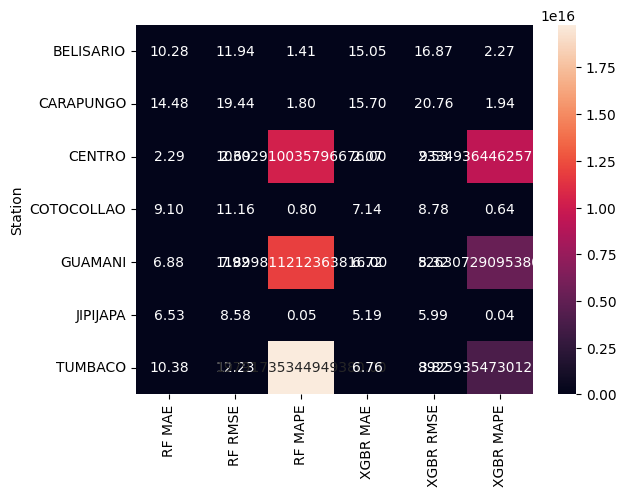

In [ ]:
sns.heatmap(errors_df, annot=True, fmt=".2f")

La visualización mostrada es un mapa de calor (heatmap) que ilustra los errores de predicción para diferentes estaciones y modelos. El heatmap utiliza el DataFrame de errores calculado previamente, donde cada celda representa un valor de error específico para una estación y un modelo. Los colores indican la magnitud de los errores, con tonos más oscuros representando valores más bajos y tonos más claros representando valores más altos. Las anotaciones en las celdas muestran los valores exactos de error, formateados a dos decimales para mayor claridad. Este gráfico permite identificar rápidamente qué modelo tiene mejor rendimiento en cada estación y resaltar las áreas donde las predicciones son menos precisas.

# Conclusiones y Recomendaciones


Conclusiones:
Variabilidad en el rendimiento entre estaciones: Los errores de predicción varían significativamente entre diferentes estaciones. Por ejemplo, las estaciones como "CENTRO" y "GUAMANI" presentan errores notablemente altos en MAPE para ciertos modelos, indicando que las predicciones en estas ubicaciones son menos precisas.

Comparación de modelos:

RandomForestRegressor tiende a tener un rendimiento más consistente en términos de MAE y RMSE a través de las estaciones, pero presenta valores de MAPE extremadamente altos en algunas estaciones, lo que sugiere que este modelo tiene dificultades con ciertas variaciones de los datos.
XGBRegressor también muestra variabilidad en el rendimiento, con algunos errores notablemente altos en MAPE, aunque en términos de MAE y RMSE, muestra resultados competitivos en varias estaciones.
Problemas específicos: Las estaciones como "CENTRO" y "GUAMANI" muestran problemas específicos donde ambos modelos presentan altos errores en MAPE, indicando que los modelos no están capturando correctamente las características de los datos en estas ubicaciones.

Recomendaciones:
Ajuste y reentrenamiento de modelos:

Realizar un análisis detallado de las características de los datos en estaciones con altos errores, como "CENTRO" y "GUAMANI", para entender mejor las razones detrás de las predicciones imprecisas.
Considerar el uso de técnicas de ingeniería de características adicionales o modelos híbridos que puedan capturar mejor la variabilidad en estas estaciones.
Validación cruzada específica por estación:

Implementar técnicas de validación cruzada que tengan en cuenta la variabilidad por estación para asegurar que los modelos se ajusten adecuadamente a las particularidades de cada estación.
Uso de modelos adicionales:

Explorar el uso de otros modelos de machine learning o combinaciones de modelos (ensemble methods) que puedan ofrecer mejoras en la precisión de las predicciones, especialmente en estaciones con alta variabilidad.
Preprocesamiento de datos:

Asegurar un preprocesamiento más robusto de los datos, incluyendo la normalización y el manejo de valores atípicos, que podrían estar afectando negativamente el rendimiento de los modelos en ciertas estaciones.
Monitoreo y actualización continua:

Implementar un sistema de monitoreo continuo para las predicciones y actualizar los modelos regularmente con nuevos datos para mejorar su precisión y adaptabilidad a cambios en las condiciones ambientales.
Estas recomendaciones buscan mejorar la precisión de las predicciones y hacer los modelos más robustos y adaptables a diferentes condiciones y variabilidades presentes en los datos de cada estación.